# 使用集合模式的聊天机器人

## 回顾

我们让聊天机器人把语义记忆保存到单一的[用户档案](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)中。

同时，我们引入了库 [Trustcall](https://github.com/hinthornw/trustcall)，用于向该模式写入新信息。

## 目标

有时，我们更希望把记忆保存到[集合](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_200)而非单一档案。

接下来我们会更新聊天机器人，让它[把记忆保存到集合](https://langchain-ai.github.io/langgraph/concepts/memory/#collection)。

同时展示如何使用 [Trustcall](https://github.com/hinthornw/trustcall) 来更新集合。


In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [2]:
import os, getpass


def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")

    # Set the environment variable for the current process
    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 定义集合模式

与其在固定档案结构中存储用户信息，我们会创建一个更灵活的集合模式，用来保存与用户互动相关的记忆。

每条记忆将作为独立条目保存，核心信息存放在 `content` 字段。

这种方式能够动态构建一个开放式集合，随着我们了解更多用户信息而不断扩展。

我们可以把集合模式定义为一个 [Pydantic](https://docs.pydantic.dev/latest/) 对象。


In [3]:
from pydantic import BaseModel, Field


class Memory(BaseModel):
    content: str = Field(
        description="The main content of the memory. For example: User expressed interest in learning about French."
    )


class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [4]:
# _set_env("OPENAI_API_KEY")
_set_env("DASHSCOPE_API_KEY")

我们可以利用 LangChain [聊天模型](https://python.langchain.com/docs/concepts/chat_models/)接口的 [`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) 方法来保证结构化输出。


In [5]:
from langchain_core.messages import HumanMessage

# from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi

# Initialize the model
# model = ChatOpenAI(model="gpt-4o", temperature=0)
model = ChatTongyi(model="qwen3-max", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke(
    [HumanMessage("My name is Lance. I like to bike.")]
)
memory_collection.memories

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


[Memory(content="User's name is Lance."),
 Memory(content='Lance likes to bike.')]

我们可以通过 `model_dump()` 将 Pydantic 模型实例序列化为 Python 字典。


In [6]:
memory_collection.memories[0].model_dump()

{'content': "User's name is Lance."}

把每条记忆的字典表示写入存储。


In [7]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

在存储中检索这些记忆。


In [8]:
# Search
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': '0003d0a6-e6ce-4161-af59-8b506b8a673f', 'value': {'content': "User's name is Lance."}, 'created_at': '2025-09-29T14:01:31.637685+00:00', 'updated_at': '2025-09-29T14:01:31.637689+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': '972510d1-252b-419f-a32d-3623777eccc2', 'value': {'content': 'Lance likes to bike.'}, 'created_at': '2025-09-29T14:01:31.637752+00:00', 'updated_at': '2025-09-29T14:01:31.637753+00:00', 'score': None}


## 更新集合模式

上一课我们提到更新档案模式的挑战。

集合同样如此！

我们希望既能向集合中添加新记忆，也能更新已存在的记忆。

下面展示如何使用 [Trustcall](https://github.com/hinthornw/trustcall) 来更新集合。

这既支持新增，也支持[更新集合中的已有条目](https://github.com/hinthornw/trustcall?tab=readme-ov-file#simultanous-updates--insertions)。

我们将定义一个新的 Trustcall 抽取器。

依旧提供单条记忆的模式 `Memory`。

此外，通过 `enable_inserts=True` 允许抽取器向集合插入新记忆。


In [9]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    # tool_choice="Memory",
    tool_choice="auto",
    enable_inserts=True,
)

In [10]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [
    HumanMessage(content="Hi, I'm Lance."),
    AIMessage(content="Nice to meet you, Lance."),
    HumanMessage(content="This morning I had a nice bike ride in San Francisco."),
]

# Invoke the extractor
result = trustcall_extractor.invoke(
    {"messages": [SystemMessage(content=instruction)] + conversation}
)

In [11]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_75e95ec2a50e42f79269658b)
 Call ID: call_75e95ec2a50e42f79269658b
  Args:
    content: Lance had a nice bike ride in San Francisco this morning.


In [12]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]:
    print(m)

content='Lance had a nice bike ride in San Francisco this morning.'


In [13]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_75e95ec2a50e42f79269658b'}


In [14]:
# Update the conversation
updated_conversation = [
    AIMessage(content="That's great, did you do after?"),
    HumanMessage(content="I went to Tartine and ate a croissant."),
    AIMessage(content="What else is on your mind?"),
    HumanMessage(content="I was thinking about my Japan, and going back this winter!"),
]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = (
    [
        (str(i), tool_name, memory.model_dump())
        for i, memory in enumerate(result["responses"])
    ]
    if result["responses"]
    else None
)
existing_memories

[('0',
  'Memory',
  {'content': 'Lance had a nice bike ride in San Francisco this morning.'})]

In [15]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke(
    # {"messages": updated_conversation, "existing": existing_memories}
    {"messages": updated_conversation},
    {"existing": existing_memories},
)

In [16]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_554d75674ede439aaae82f69)
 Call ID: call_554d75674ede439aaae82f69
  Args:
    content: User is planning to go back to Japan this winter.


In [17]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]:
    print(m)

content='User is planning to go back to Japan this winter.'


这说明我们通过 `json_doc_id` 指定了集合中第一条记忆并对其进行了更新。


In [18]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_554d75674ede439aaae82f69'}


LangSmith 追踪：

https://smith.langchain.com/public/ebc1cb01-f021-4794-80c0-c75d6ea90446/r


## 可以更新集合模式的聊天机器人

现在，我们把 Trustcall 集成进聊天机器人，实现记忆集合的创建与更新。


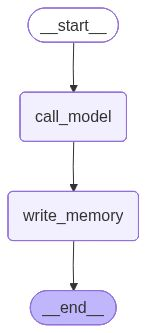

In [ ]:
from IPython.display import Image, display

import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
# model = ChatOpenAI(model="gpt-4o", temperature=0)
model = ChatTongyi(model="qwen3-max", temperature=0)


# Memory schema
class Memory(BaseModel):
    content: str = Field(
        description="The main content of the memory. For example: User expressed interest in learning about French."
    )


# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    # tool_choice="Memory",
    tool_choice="auto",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user. 

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation): 

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously:"""


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memories from the store and use them to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = (
        [
            (existing_item.key, tool_name, existing_item.value)
            for existing_item in existing_items
        ]
        if existing_items
        else None
    )

    # Merge the chat history and the instruction
    updated_messages = list(
        merge_message_runs(
            messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]
        )
    )

    # Invoke the extractor
    result = trustcall_extractor.invoke(
        # {"messages": updated_messages, "existing": existing_memories}
        {"messages": updated_messages},
        {"existing": existing_memories},
    )

    # Save the memories from Trustcall to the store
    # 如果rmeta中有json_doc_id，就用它作为key【更新】，否则生成一个新的uuid【插入】
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(
            namespace,
            rmeta.get("json_doc_id", str(uuid.uuid4())),
            r.model_dump(mode="json"),
        )


# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [20]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance! Nice to meet you. How's your day going?


In [21]:
# User input
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That’s awesome, Lance! San Francisco is such a cool city to bike through—though I’ve heard the hills can be quite a workout! Do you have a favorite route or spot you like to ride to?


In [22]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': '7d3d0c34-3ce0-498e-a264-22392ec09d35', 'value': {'content': 'User introduced themselves as Lance.'}, 'created_at': '2025-09-29T14:01:48.136125+00:00', 'updated_at': '2025-09-29T14:01:48.136126+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': 'a6759364-0310-4185-be9d-cbd17e23b73f', 'value': {'content': 'Lance enjoys biking around San Francisco.'}, 'created_at': '2025-09-29T14:01:54.037339+00:00', 'updated_at': '2025-09-29T14:01:54.037340+00:00', 'score': None}


In [23]:
# User input
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Nice! Biking and bakeries—a perfect combo. San Francisco has some fantastic spots for pastries and fresh bread. Do you have a favorite bakery you like to pedal to? Maybe Tartine, B. Patisserie, or somewhere more hidden? 🥐🚲


在新线程中继续对话。


In [24]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since you enjoy biking around San Francisco and visiting bakeries, here are a few local favorites that are perfect to explore on two wheels—each with great charm and delicious treats:

1. **Tartine Bakery (Mission District)**  
   A San Francisco institution! Famous for its morning buns, country bread, and croissants. It can get busy, but it’s worth the stop—especially if you time it right after a ride through Dolores Park.

2. **Arizmendi Bakery (Inner Sunset)**  
   A worker-owned cooperative offering amazing sourdough pizza and pastries. Their seasonal fruit galettes and morning buns are standouts. Plus, it’s near Golden Gate Park—great for a post-ride snack.

3. **B. Patisserie (Pacific Heights)**  
   Known for its kouign-amann (a buttery, caramelized pastry), this place is a must 

In [25]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': '7d3d0c34-3ce0-498e-a264-22392ec09d35', 'value': {'content': 'User introduced themselves as Lance.'}, 'created_at': '2025-09-29T14:01:48.136125+00:00', 'updated_at': '2025-09-29T14:01:48.136126+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': 'a6759364-0310-4185-be9d-cbd17e23b73f', 'value': {'content': 'Lance enjoys biking around San Francisco.'}, 'created_at': '2025-09-29T14:01:54.037339+00:00', 'updated_at': '2025-09-29T14:01:54.037340+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '35c82ec0-9b9c-4e3f-954a-407a4a4e3180', 'value': {'content': 'Lance enjoys biking around San Francisco and visiting bakeries.'}, 'created_at': '2025-09-29T14:02:07.080867+00:00', 'updated_at': '2025-09-29T14:02:07.080868+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '816f1b12-b57a-4f1d-a19b-da8f829bb834', 'value': {'content': 'The user enjoys biking around San Francisco and visiting bakeries.'}, 'created_at': '2025-09-29

### LangSmith

https://smith.langchain.com/public/c87543ec-b426-4a82-a3ab-94d01c01d9f4/r

## Studio

![Screenshot 2024-10-30 at 11.29.25 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0876d3daa19fef993ba_Screenshot%202024-11-11%20at%207.50.21%E2%80%AFPM.png)
